<a href="https://colab.research.google.com/github/Sifael/JudithFlorenceFoundation/blob/main/VAE_Explorations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Advanced Project II - Exploring VAE Techniques to Improve Fidelity of Images

This notebook explores the use of VAE techniques to improve the fidelity of images. In particular, the goal is to replicate the work performed by the paper Taming VAEs.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Configuring the notebook to access VAE Folder which contains the data.


In [2]:
import os
os.chdir('/content/drive/MyDrive/VAE')

### Loading MNIST Data

So far, I have failed to download the dataset using Pytorch. Therefore, I have to use the downloaded `gz`. Now, I have to process the data here.

In [3]:
import os
import numpy as np
import torch
import gzip
from torch.utils.data import TensorDataset, DataLoader

# Function to load MNIST dataset
def load_mnist_images(filename):
    """Load MNIST images from the given .ubyte file"""
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        return data.reshape(-1, 28, 28) / 255.0  # Normalize to [0,1] range

def load_mnist_labels(filename):
    """Load MNIST labels from the given .ubyte file"""
    with gzip.open(filename, 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=8)


data_path = "."

train_images_path = os.path.join(data_path, "train-images-idx3-ubyte.gz")
train_labels_path = os.path.join(data_path, "train-labels-idx1-ubyte.gz")
test_images_path = os.path.join(data_path, "t10k-images-idx3-ubyte.gz")
test_labels_path = os.path.join(data_path, "t10k-labels-idx1-ubyte.gz")

# Load dataset
train_images = load_mnist_images(train_images_path)
train_labels = load_mnist_labels(train_labels_path)
test_images = load_mnist_images(test_images_path)
test_labels = load_mnist_labels(test_labels_path)

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  # Add channel dim
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create PyTorch Datasets
train_set = TensorDataset(train_images_tensor, train_labels_tensor)
test_set = TensorDataset(test_images_tensor, test_labels_tensor)

# Print dataset size
print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")
print(f"Sample image shape: {train_set[0][0].shape}")

Train set size: 60000
Test set size: 10000
Sample image shape: torch.Size([1, 28, 28])


In [4]:
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

batch_size = 300
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

In [5]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

## Setting up Taming VAE Models

We now implement the taming the model

In [6]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torch

import torchvision
import time

In [7]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [8]:
from model import VAE, IVAE
from train import train_geco, train_beta
from utils import sample_vae, marginal_KL, Compute_NLL
#import datasets

In [9]:
vae_model_beta1 =  VAE(dims = [28*28, 512, 256], dim_latent = 200)
vae_model_beta1.to(device)

VAE(
  (encode): Sequential(
    (Linear_1): Linear(in_features=784, out_features=512, bias=True)
    (ReLU_1): ReLU()
    (Linear_2): Linear(in_features=512, out_features=256, bias=True)
    (ReLU_2): ReLU()
  )
  (decode): Sequential(
    (Linear_1): Linear(in_features=200, out_features=256, bias=True)
    (ReLU_1): ReLU()
    (Linear_2): Linear(in_features=256, out_features=512, bias=True)
    (ReLU_2): ReLU()
  )
  (latent_mu): Linear(in_features=256, out_features=200, bias=True)
  (latent_logsigma): Linear(in_features=256, out_features=200, bias=True)
  (reconstruction_mu): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Sigmoid()
  )
  (reconstruction_logsigma): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

<br>

### Implementing the Train Function.

On this example, we will explore the VAE model and train it against the MNIST dataset.

In [10]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from IPython import display

import argparse
import torchvision

def KL_divergence(mu, logsigma):
    return - 0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - logsigma.exp().pow(2), dim=1)

def log_likelihood(x, mu, logsigma):
    return torch.sum(- logsigma - 0.5 * np.log(2 * np.pi) - (mu - x).pow(2) / (2 * logsigma.exp().pow(2)), dim=1)

def RE(x, mu, tol):
    return torch.sum(torch.pow(mu - x, 2), dim = 1) - tol**2

def RE_mtr(x, mu, tol):
    return torch.sum(torch.pow(mu - x, 2), dim = (1, 2)) - tol**2

def loss_beta_vae(x, mu_gen, logsigma_gen, mu_latent, logsigma_latent, beta=1):
    return torch.mean(beta * KL_divergence(mu_latent, logsigma_latent) - log_likelihood(x, mu_gen, logsigma_gen))

def loss_beta_vae(x, mu_gen, logsigma_gen, mu_latent, logsigma_latent, beta=1):
    return torch.mean(beta * KL_divergence(mu_latent, logsigma_latent) - log_likelihood(x, mu_gen, logsigma_gen))

def draw_hist(train_hist, valid_hist, lambd_hist = [0]):
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 4))

    ax[0].plot(train_hist['loss'], label = 'train')
    ax[0].plot(valid_hist['loss'], label = 'test')
    ax[0].legend()
    ax[0].set_title("Total Loss")

    ax[1].plot(train_hist['reconstr'], label = 'train')
    ax[1].plot(valid_hist['reconstr'], label = 'test')
    ax[1].legend()
    ax[1].set_title("Reconstruction")

    ax[2].plot(train_hist['KL'], label = 'train')
    ax[2].plot(valid_hist['KL'], label = 'test')
    ax[2].legend()
    ax[2].set_title("KL divergence")

    ax[3].plot(lambd_hist)
    ax[3].set_title("Lambda")
    plt.show()

def train_beta(model, opt, scheduler, train_loader, valid_loader, device='cuda',
               loss_beta_vae=loss_beta_vae, num_epochs=20, beta=1):

    train_hist = {'loss': [], 'reconstr': [], 'KL': []}
    valid_hist = {'loss': [], 'reconstr': [], 'KL': []}
    model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True)

        # Initialize loss tracking
        train_hist['loss'].append(0)
        train_hist['reconstr'].append(0)
        train_hist['KL'].append(0)

        for X_batch, _ in train_loader:  # Unpack batch: (images, labels)
            X_batch = X_batch.view(X_batch.size(0), -1).to(device)  # Reshape properly

            # Ensure model forward matches expected output
            output = model.forward(X_batch)

            # Handle extra return values from forward()
            if len(output) == 5:
                reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, _ = output
            else:
                reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = output

            # Compute loss
            loss = loss_beta_vae(X_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, beta)
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Accumulate loss
            train_hist['loss'][-1] += loss.item() / len(train_loader)

        # Validation phase
        model.eval()
        valid_hist['loss'].append(0)
        valid_hist['reconstr'].append(0)
        valid_hist['KL'].append(0)

        with torch.no_grad():
            for X_batch, _ in valid_loader:  # Unpack batch properly
                X_batch = X_batch.view(X_batch.size(0), -1).to(device)

                output = model.forward(X_batch)

                if len(output) == 5:
                    reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, _ = output
                else:
                    reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = output

                loss = loss_beta_vae(X_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, beta)
                valid_hist['loss'][-1] += loss.item() / len(valid_loader)

        # Update learning rate scheduler
        if scheduler is not None:
            scheduler.step(valid_hist['loss'][-1])

        # Early stopping if learning rate is too small
        if opt.param_groups[0]['lr'] <= 1e-6:
            break

        # Visualization
        display.clear_output(wait=True)
        draw_hist(train_hist, valid_hist)

        # Print Epoch Stats
        print(f"Epoch {epoch + 1} of {num_epochs} took {time.time() - start_time:.3f}s")
        print(f"  Training loss: {train_hist['loss'][-1]:.6f}")
        print(f"  Validation loss: {valid_hist['loss'][-1]:.6f}")


In [12]:
optimizer = optim.Adam(vae_model_beta1.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

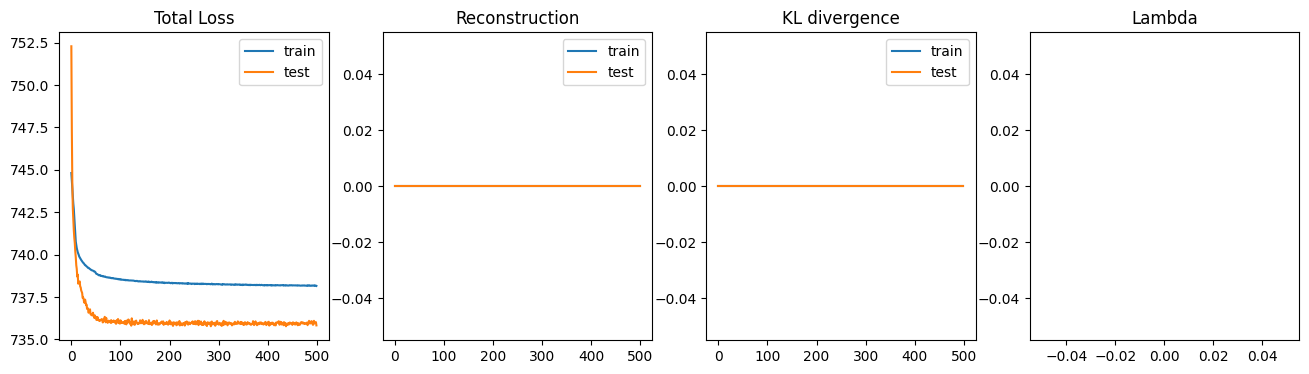

Epoch 500 of 500 took 1.660s
  Training loss: 738.158830
  Validation loss: 735.830411


In [14]:
train_beta(vae_model_beta1, optimizer, scheduler, train_loader, test_loader, num_epochs=500, beta=1)

<br>

### Visualizing the Results from the first model

With this model, the beta argument is set to 1. We visualize the results and compare.



In [25]:
def visualize_reconstructions(model, data_loader, device='cuda', num_images=10):
    """
    Visualizes original and reconstructed images from a trained VAE model.

    Parameters:
        model: Trained VAE model
        data_loader: DataLoader for MNIST dataset
        device: 'cuda' or 'cpu'
        num_images: Number of images to visualize
    """
    model.eval()  # Set model to evaluation mode

    # Get a batch of images from the test set
    images, _ = next(iter(data_loader))  # Ignore labels
    images = images[:num_images].to(device)  # Select a few images

    # Flatten images before passing to model
    images_flat = images.view(images.size(0), -1)

    # Forward pass through VAE
    with torch.no_grad():
        output = model(images_flat)

    # Handle extra return values if necessary
    if len(output) == 5:
        reconstruction_mu, reconstruction_logsigma, _, _, _ = output
    else:
        reconstruction_mu, reconstruction_logsigma, _, _ = output

    # Reshape back to image format (28x28)
    reconstructions = reconstruction_mu.view(-1, 28, 28).cpu()

    # Convert originals to CPU for plotting
    originals = images.view(-1, 28, 28).cpu()

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images, 2))

    for i in range(num_images):
        # Original image
        axes[0, i].imshow(originals[i], cmap='gray')
        axes[0, i].axis('off')

        # Reconstructed image
        axes[1, i].imshow(reconstructions[i], cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_title("Originals", fontsize=12)
    axes[1, 0].set_title("Reconstructions", fontsize=12)

    plt.tight_layout()
    plt.show()


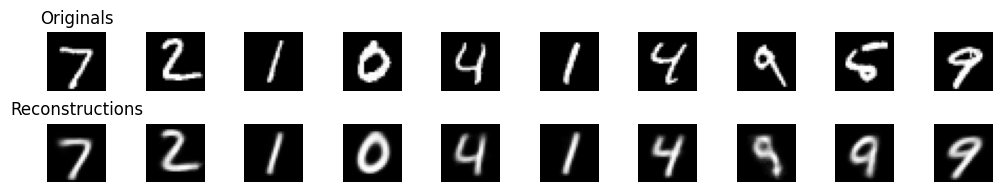

In [26]:
visualize_reconstructions(vae_model_beta1, test_loader, device='cuda', num_images=10)

## $beta=.5$ - Testing a Model with a Different Beta Criteria

Say $beta=.5$.


In [17]:

# defining the model
vae_model_beta05 =  VAE(dims = [28*28, 512, 256], dim_latent = 200)
vae_model_beta05.to(device)

optimizer = optim.Adam(vae_model_beta05.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

def train_beta(model, opt, scheduler, train_loader, valid_loader, device='cuda',
               loss_beta_vae=loss_beta_vae, num_epochs=100, beta=.5):

    train_hist = {'loss': [], 'reconstr': [], 'KL': []}
    valid_hist = {'loss': [], 'reconstr': [], 'KL': []}
    model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True)

        # Initialize loss tracking
        train_hist['loss'].append(0)
        train_hist['reconstr'].append(0)
        train_hist['KL'].append(0)

        for X_batch, _ in train_loader:  # Unpack batch: (images, labels)
            X_batch = X_batch.view(X_batch.size(0), -1).to(device)  # Reshape properly

            # Ensure model forward matches expected output
            output = model.forward(X_batch)

            # Handle extra return values from forward()
            if len(output) == 5:
                reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, _ = output
            else:
                reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = output

            # Compute loss
            loss = loss_beta_vae(X_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, beta)
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Accumulate loss
            train_hist['loss'][-1] += loss.item() / len(train_loader)

        # Validation phase
        model.eval()
        valid_hist['loss'].append(0)
        valid_hist['reconstr'].append(0)
        valid_hist['KL'].append(0)

        with torch.no_grad():
            for X_batch, _ in valid_loader:  # Unpack batch properly
                X_batch = X_batch.view(X_batch.size(0), -1).to(device)

                output = model.forward(X_batch)

                if len(output) == 5:
                    reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, _ = output
                else:
                    reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = output

                loss = loss_beta_vae(X_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, beta)
                valid_hist['loss'][-1] += loss.item() / len(valid_loader)

        # Update learning rate scheduler
        if scheduler is not None:
            scheduler.step(valid_hist['loss'][-1])

        # Early stopping if learning rate is too small
        if opt.param_groups[0]['lr'] <= 1e-6:
            break

        # Visualization
        display.clear_output(wait=True)
        draw_hist(train_hist, valid_hist)

        # Print Epoch Stats
        print(f"Epoch {epoch + 1} of {num_epochs} took {time.time() - start_time:.3f}s")
        print(f"  Training loss: {train_hist['loss'][-1]:.6f}")
        print(f"  Validation loss: {valid_hist['loss'][-1]:.6f}")



training the $beta=.5$ model

In [19]:
train_beta(vae_model_beta05 , optimizer, scheduler, train_loader, test_loader, num_epochs=400, beta=.5)

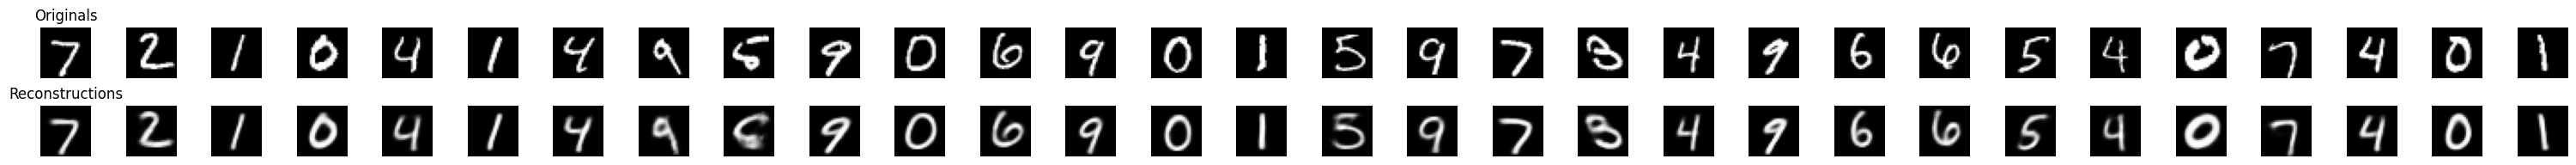

In [30]:
visualize_reconstructions(vae_model_beta05, test_loader, device='cuda', num_images=30)



## GECO Model Experimentation on MNIST

This section tests the GECO Implementation.






In [21]:
def train_geco(model, opt, scheduler, train_loader, valid_loader,
               lambd_init=torch.FloatTensor([1]),
               KL_divergence=KL_divergence,
               constraint_f=RE, num_epochs=20,
               lbd_step=100, alpha=0.99, visualize=True,
               device='cpu', tol=1, pretrain=1):

    model.to(device)
    train_hist = {'loss': [], 'reconstr': [], 'KL': []}
    valid_hist = {'loss': [], 'reconstr': [], 'KL': []}
    lambd_hist = []

    lambd = lambd_init.to(device)
    iter_num = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        train_hist['loss'].append(0)
        train_hist['reconstr'].append(0)
        train_hist['KL'].append(0)

        for X_batch, _ in train_loader:  # Unpacking correctly
            X_batch = X_batch.to(device)  # Move to correct device
            X_batch = X_batch.view(X_batch.size(0), -1)  # Flatten (batch_size, 784)

            opt.zero_grad()  # Zero gradients

            reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, _ = model(X_batch)
            constraint = torch.mean(constraint_f(X_batch, reconstruction_mu, tol=tol))
            KL_div = torch.mean(KL_divergence(latent_mu, latent_logsigma))
            loss = KL_div + lambd * constraint

            loss.backward()
            opt.step()

            with torch.no_grad():
                if epoch == 0 and iter_num == 0:
                    constrain_ma = constraint
                else:
                    constrain_ma = alpha * constrain_ma.detach() + (1 - alpha) * constraint
                if iter_num % lbd_step == 0 and epoch > pretrain:
                    lambd *= torch.clamp(torch.exp(constrain_ma), 0.9, 1.1)

            train_hist['loss'][-1] += loss.item() / len(train_loader)
            train_hist['reconstr'][-1] += constraint.item() / len(train_loader)
            train_hist['KL'][-1] += KL_div.item() / len(train_loader)
            iter_num += 1

        lambd_hist.append(lambd.item())

        model.eval()
        valid_hist['loss'].append(0)
        valid_hist['reconstr'].append(0)
        valid_hist['KL'].append(0)

        with torch.no_grad():
            for X_batch, _ in valid_loader:
                X_batch = X_batch.to(device)
                X_batch = X_batch.view(X_batch.size(0), -1)

                reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, _ = model(X_batch)

                constraint = torch.mean(constraint_f(X_batch, reconstruction_mu, tol=tol))
                KL_div = torch.mean(KL_divergence(latent_mu, latent_logsigma))
                loss = KL_div + lambd * constraint

                valid_hist['loss'][-1] += loss.item() / len(valid_loader)
                valid_hist['reconstr'][-1] += constraint.item() / len(valid_loader)
                valid_hist['KL'][-1] += KL_div.item() / len(valid_loader)

        # Update learning rate
        if scheduler is not None:
            scheduler.step(valid_hist['loss'][-1])

        # Stop if learning rate is too low
        if opt.param_groups[0]['lr'] <= 1e-6:
            break

        # Visualization
        if visualize:
            display.clear_output(wait=True)
            draw_hist(train_hist, valid_hist, lambd_hist)

        print(f"Epoch {epoch + 1}/{num_epochs} took {time.time() - start_time:.3f}s")
        print(f"  Training loss: {train_hist['loss'][-1]:.6f}")
        print(f"  Validation loss: {valid_hist['loss'][-1]:.6f}")

    return train_hist, valid_hist, lambd_hist

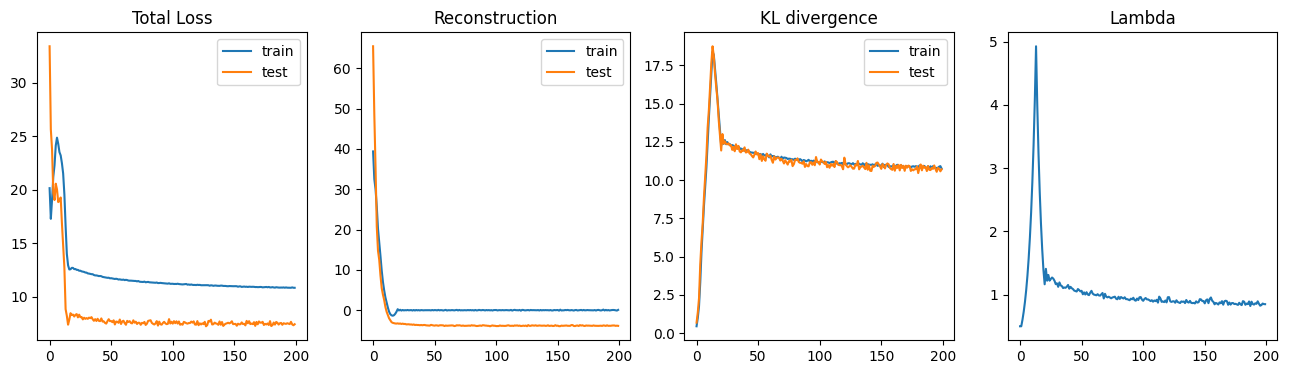

Epoch 200/200 took 1.575s
  Training loss: 10.818575
  Validation loss: 7.409044


({'loss': [20.141928730010974,
   17.272745704650877,
   19.071172151565545,
   21.21413761138915,
   22.289684877395644,
   24.12379151344299,
   24.870205688476574,
   24.297796525955214,
   23.514350538253787,
   23.20691546440125,
   22.482805271148685,
   21.519690809249877,
   19.562537040710446,
   16.602613744735706,
   13.987373995780946,
   12.928746027946474,
   12.534953513145455,
   12.556151709556577,
   12.68623004436493,
   12.679959144592289,
   12.564625477790836,
   12.575725212097165,
   12.497008323669435,
   12.496615395545959,
   12.413673725128174,
   12.417351856231688,
   12.354754228591924,
   12.327661304473876,
   12.304504680633539,
   12.247562203407291,
   12.238173990249633,
   12.165064392089846,
   12.1488759279251,
   12.121561756134032,
   12.093733453750618,
   12.088471493721011,
   12.013287377357484,
   11.978169803619386,
   11.976172885894771,
   11.951086640357966,
   11.913705468177794,
   11.923416662216189,
   11.901768999099732,
   11.838

In [22]:
vae_model_geco =  VAE(dims = [28*28, 512, 256], dim_latent = 200)
vae_model_geco.to(device)

optimizer = optim.Adam(vae_model_geco.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)
scheduler = None
train_geco(vae_model_geco, optimizer, scheduler,
           train_loader = train_loader,
           valid_loader = test_loader,
           device = device, lbd_step = 100,
           num_epochs=200,lambd_init = torch.FloatTensor([0.5]),
           tol = 4)

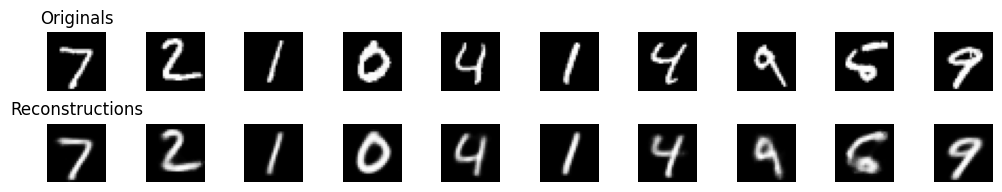

In [28]:
visualize_reconstructions(vae_model_geco, test_loader, device='cuda', num_images=10)